In [43]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq

# Load environment variables
load_dotenv()

# Initialize LLaMA3 model
llm = ChatGroq(model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7c73f3ae2e90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7c73f3ae1f90>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

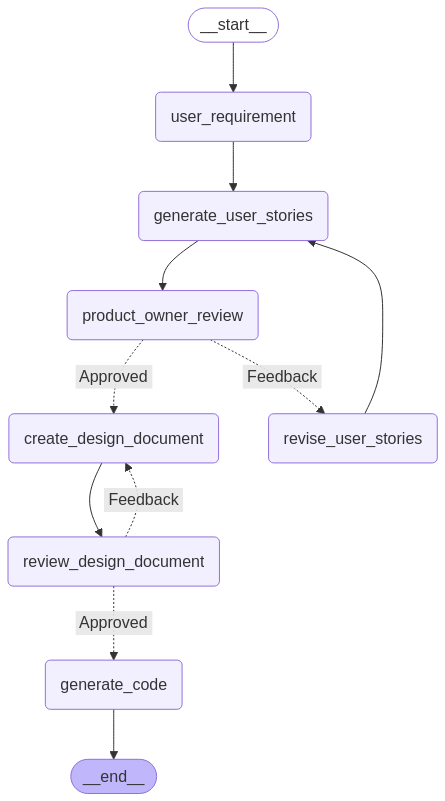

In [79]:
from IPython.display import Image
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END

class UserStory(BaseModel):
    title: str = Field(
        description="Title of the user story summarizing the functionality."
    )
    description: str = Field(
        description="Detailed user story following the format: 'As a [user], I want to [action] so that [benefit]'."
    )
    acceptance_criteria: List[str] = Field(
        description="List of acceptance criteria that define when this story is complete."
    )


class UserStories(BaseModel):
    stories: List[UserStory] = Field(
        default_factory=list, description="List of generated user stories."
    )
    
# UserStory schema for structured output
user_story_evaluator = llm.with_structured_output(UserStories)

def format_user_stories(user_stories: UserStories):
    """Formats all user stories to ensure correct title formatting."""
    for story in user_stories.stories:
        story.format_title()

# Define the graph state
class State(TypedDict):
    prompt: str
    content: str
    user_stories: UserStories
    product_owner_review_status: str
    design_document_review_status: str

# def get_user_requirement(state: State):
#     """Generates structured user stories from user requirements using the `UserStories` schema."""
#     result = user_story_evaluator.invoke(
#         f"Split the following requirements into distinct user stories. "
#         f"Each user story should include a title, description, and acceptance criteria: {state['prompt']}"
#     )
#     return {"user_stories": result}

# def generate_user_stories(state: State):
#     if not state["user_stories"].stories:
#         print("No user stories found.")
#         return

#     for story in state["user_stories"].stories:
#         print("Title:", story.title)  
#         print("Description:", story.description)
#         print("Acceptance Criteria:", story.acceptance_criteria)           
#         print("\n\n")     
        
def get_user_requirement(state: State):
    pass

def generate_user_stories(state: State):
    pass

def review_by_product_owner(state: State):
    pass   

def revise_user_stories(state: State):
    pass

def create_design_document(state: State):
    pass

def review_design_document(state:State):
    pass

def generate_code(state: State):
    pass

def route_product_owner_review(state: State):
    if state["product_owner_review_status"] == "approved":
        return "Approved"
    elif state["product_owner_review_status"] == "feedback":
        return "Feedback"

def route_review_design_document(state: State):
    if state["design_document_review_status"] == "approved":
        return "Approved"
    elif state["design_document_review_status"] == "feedback":
        return "Feedback"
    
# Build the workflow
optimizer_builder = StateGraph(State)
optimizer_builder.add_node("user_requirement", get_user_requirement)
optimizer_builder.add_node("generate_user_stories", generate_user_stories)
optimizer_builder.add_node("product_owner_review", review_by_product_owner)
optimizer_builder.add_node("revise_user_stories", revise_user_stories)
optimizer_builder.add_node("create_design_document", create_design_document)
optimizer_builder.add_node("review_design_document", review_design_document)
optimizer_builder.add_node("generate_code", generate_code)

optimizer_builder.add_edge(START, "user_requirement")
optimizer_builder.add_edge("user_requirement", "generate_user_stories")
optimizer_builder.add_edge("generate_user_stories", "product_owner_review")
optimizer_builder.add_conditional_edges(
    "product_owner_review",
    route_product_owner_review,
    {
        "Approved": "create_design_document",
        "Feedback": "revise_user_stories"
    }
)
optimizer_builder.add_edge("revise_user_stories", "generate_user_stories")
optimizer_builder.add_edge("create_design_document", "review_design_document")
optimizer_builder.add_conditional_edges(
    "review_design_document",
    route_review_design_document,
    {
        "Approved": "generate_code",
        "Feedback": "create_design_document"
    }
)
optimizer_builder.add_edge("generate_code", END)

# Compile
optimizer_workflow = optimizer_builder.compile()

display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

prompt = "I want to develop a user management system with two user types: Admin and User. Admins will have the ability to create, list, update, and delete users, while Users will only be able to retrieve their own details using their user ID."
initial_state = {
    "prompt":prompt,
    "content": "",
    "user_stories": UserStories(stories=[]),  
    "product_owner_review_status": "approved",  
    "design_document_review_status": "approved",
}
state = optimizer_workflow.invoke(initial_state)
